In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import re
import os

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.ar import Arabic


import torch
import torch.nn as nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Loading & Pre-processing

In [ ]:
df = pd.read_csv("data/arabic_english.txt",delimiter="\t",names=["en","ar"])
df.head()

,en,ar
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!


In [ ]:

!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!pip install torchtext==0.6.0

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import string
import pandas as pd
import regex as re
import nltk

arabic_stopwords = set(nltk.corpus.stopwords.words("arabic"))
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''

punctuations = arabic_punctuations + string.punctuation


def load(name):
    file = open(name, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text

def senticize(doc):
	return doc.strip().split('\n')

def len_sents(sentences):
	l = [len(s.split()) for s in sentences]
	return min(l), max(l)

# stop words removal
def rem_swords(ct):
    filered = [w for w in ct.split() if w not in punctuations]
    return ' '.join(filered)

def clean(line):
    if (isinstance(line, float)):
        return None
    line.replace('\n', ' ')
    line = ' '.join(line)
    trans = str.maketrans('','', punctuations)
    line = line.translate(trans)
    line = ' '.join(line)
    return line

In [ ]:
seeding = 32
spacy_eng = spacy.load("en_core_web_sm")
arab = Arabic()
ar_tk = Tokenizer(arab.vocab)

#from torchtext.legacy import data
from torchtext import data, datasets
from torchtext.vocab import Vocab
from torchtext import data

def tk_en(content):
  return [w.text for w in spacy_eng.tokenizer(content)]

def tk_ar(content):
  return [w.text for w in
  ar_tk(re.sub(r"\s+"," ",re.sub(r"[\.\'\"\n+]"," ",content)).strip())]

SRC = data.Field(tokenize=tk_en,batch_first=False,init_token="<sos>",eos_token="<eos>")
TRG = data.Field(tokenize=tk_ar,batch_first=False,tokenizer_language="ar",init_token="بداية",eos_token="نهاية")

class Textsizing(data.Dataset):
  def __init__(self, df, src_field, target_field, is_test=False, **kwargs):
    fields = [('en', src_field), ('ar',target_field)]
    samples = []
    for i, r in df.iterrows():
      en = r.en
      ar = r.ar
      samples.append(data.Example.fromlist([en, ar], fields))
      super().__init__(samples, fields, **kwargs)

  def __len__(self):
      return len(self.samples)
  def __getitem__(self,idx):
      return self.samples[idx]


In [ ]:
df.en = df.en.apply(clean)
df

,en,ar
0,H i,مرحبًا.
1,R u n,اركض!
2,H e l p,النجدة!
3,J u m p,اقفز!
4,S t o p,قف!
...,...,...
24633,r i s i n g v o i c e ...,شاركنا تحدي ابداع ميم بلغتك الام تعزيزا للتنوع...
24634,f o l l o w i n g l a ...,استكمالا لنجاح حملة العام السابق ندعوكم للمشار...
24635,d u r i n g l a s t ...,تعرفنا خلال تحدي العام الماضي على ابطال لغويين...
24636,t o t a k e p a r t ...,للمشاركة في التحدي اتبع الخطوات الموضحة على ال...


In [ ]:
df.to_csv('data/clean.txt')

# we tokenize

In [ ]:
df = pd.read_csv("data/arabic_english.txt",delimiter="\t",names=["en","ar"])
df.head()

,en,ar
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!


In [ ]:
torchdataset = Textsizing(df,SRC,TRG)

# training & validation
tdata, vdata = torchdataset.split(split_ratio=0.8, random_state = random.seed(32))

SRC.build_vocab(tdata,min_freq=2)
TRG.build_vocab(tdata,min_freq=2)

print(tdata[1].__dict__)

{'en': ['I', 'was', 'delayed', 'by', 'a', 'traffic', 'jam', '.'], 'ar': ['أخّرني', 'زحام', 'السير']}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [69]:
class Transformer(nn.Module):
    def __init__(
        self,
        emb_size,
        svocab_size, # source vocab
        tvocab_size, ## target vocabulary
        spad_idx,
        nheads,
        nencoder_layers, # number of encoder layers
        ndecoder_layers,
        len_max
    ):
        super(Transformer, self).__init__()
        self.sembeddings = nn.Embedding(svocab_size,emb_size)
        self.spositional_embeddings= nn.Embedding(len_max,emb_size)
        self.tembeddings= nn.Embedding(tvocab_size,emb_size)
        self.tpositional_embeddings= nn.Embedding(len_max,emb_size)
        self.device = device
        self.transformer = nn.Transformer(
            emb_size,
            nheads,
            nencoder_layers,
            ndecoder_layers,
        )
        self.fc_out = nn.Linear(emb_size, tvocab_size)
        self.dropout = nn.Dropout(dropout)
        self.spad_idx = spad_idx
    def smasking(self,src):
        ## making a source mask
        smask= src.transpose(0,1) == self.spad_idx
        return smask

    def forward(self,src,trg):
        sseq_len, S = src.shape
        tseq_len, S = trg.shape
        spositions = (
            torch.arange(0, sseq_len).unsqueeze(1).expand(sseq_len, S).to(self.device)
        )
        tpositions = (
            torch.arange(0, tseq_len).unsqueeze(1).expand(tseq_len, S).to(self.device)
        )
        # source embedding
        sembed = self.dropout(
            ( self.sembeddings(src) + self.spositional_embeddings(spositions) )
        )
        # target embedding
        tembed = self.dropout(
                ( self.tembeddings(trg) + self.tpositional_embeddings(tpositions) )
        )
        # source masking
        spadding_mask = self.smasking(src)
        # target masking
        tmask = self.transformer.generate_square_subsequent_mask(tseq_len).to(device)

        out = self.transformer(sembed,tembed,src_key_padding_mask = spadding_mask, tgt_mask = tmask )
        out = self.fc_out(out)
        return out

## We do config

In [77]:
BATCH_SIZE = 16
train_iter, valid_iter = data.BucketIterator.splits(
    (tdata,vdata),
    batch_size = BATCH_SIZE,
    sort=None,
    sort_within_batch=False,
    sort_key=lambda x: len(x.en),
    device=device,
    shuffle=True
)

spad_idx = SRC.vocab.stoi["<pad>"]
BATCH_SIZE = 16
learning_rate = 0.0001
num_epochs = 30

nheads = 8
nencoder_layers = 3
ndecoder_layers = 3

len_max = 230
dropout = 0.4
emb_size = 256


svocab_size = len(SRC.vocab)
print("Size of EN vocab :", svocab_size)

tvocab_size = len(TRG.vocab)
print("Size of ES vocab :", tvocab_size)

model = Transformer(
    emb_size,
    svocab_size,
    tvocab_size,
    spad_idx,
    nheads,
    nencoder_layers,
    ndecoder_layers,
    len_max
).to(device)

Size of EN vocab : 12812
Size of ES vocab : 22067


## we get to know our architecture

In [78]:
print(model)

Transformer(
  (sembeddings): Embedding(12812, 256)
  (spositional_embeddings): Embedding(230, 256)
  (tembeddings): Embedding(22067, 256)
  (tpositional_embeddings): Embedding(230, 256)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, element

In [79]:
torch.cuda.empty_cache()

# Familiarization

In [80]:
# training and validation iterations
titer, viter = data.BucketIterator.splits(
    (tdata, vdata),
    batch_size = BATCH_SIZE,
    sort = None,
    sort_within_batch = False,
    sort_key = lambda x: len(x.en),
    device = device,
    shuffle = True
)

loss_check = []
loss_valid_check = []

optz= optim.Adam(model.parameters(), lr = learning_rate)
pad_idx = SRC.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

for epoch in range(num_epochs):
    stepLoss = []
    model.train()
    for batch in train_iter:
        input_data = batch.en.to(device)
        target = batch.ar.to(device)
        output = model(input_data, target[:-1])
        optz.zero_grad()

        output = output.reshape(-1,tvocab_size)
        target = target[1:].reshape(-1)
        loss = criterion(output, target)
        loss = criterion(output, target)
        loss.backward()
        optz.step()
        stepLoss.append(loss.item())

    loss_check.append(np.mean(stepLoss))
    print(" Epoch {} | Train Cross Entropy Loss: ".format(epoch), np.mean(stepLoss))
    with torch.no_grad():
        stepValidLoss = []
        model.eval()
        for i, batch in enumerate(valid_iter):
            inputs = batch.en.to(device)
            target = batch.ar.to(device)
            optz.zero_grad()
            output = model(inputs, target[:-1])
            output = output.reshape(-1, tvocab_size)
            target = target[1:].reshape(-1)
            loss = criterion(output,target)
            stepValidLoss.append(loss.item())
    loss_valid_check.append(np.mean(stepValidLoss))
    print("Epoch {} | Validation cross entrop loss : ".format(epoch),np.mean(stepValidLoss))

 Epoch 0 | Train Cross Entropy Loss:  7.5338118413052
Epoch 0 | Validation cross entrop loss :  6.162217096848921
 Epoch 1 | Train Cross Entropy Loss:  7.106582503814201
Epoch 1 | Validation cross entrop loss :  5.910750384454603
 Epoch 2 | Train Cross Entropy Loss:  6.916902814592634
Epoch 2 | Validation cross entrop loss :  5.748590311446748
 Epoch 3 | Train Cross Entropy Loss:  6.754502209750089
Epoch 3 | Validation cross entrop loss :  5.609222097830339
 Epoch 4 | Train Cross Entropy Loss:  6.592523202493593
Epoch 4 | Validation cross entrop loss :  5.5027931688667895
 Epoch 5 | Train Cross Entropy Loss:  6.445379098901501
Epoch 5 | Validation cross entrop loss :  5.419379747533179
 Epoch 6 | Train Cross Entropy Loss:  6.297391733565888
Epoch 6 | Validation cross entrop loss :  5.335401009429585
 Epoch 7 | Train Cross Entropy Loss:  6.1557387264517995
Epoch 7 | Validation cross entrop loss :  5.285450328480113
 Epoch 8 | Train Cross Entropy Loss:  6.005300250920382
Epoch 8 | Valida

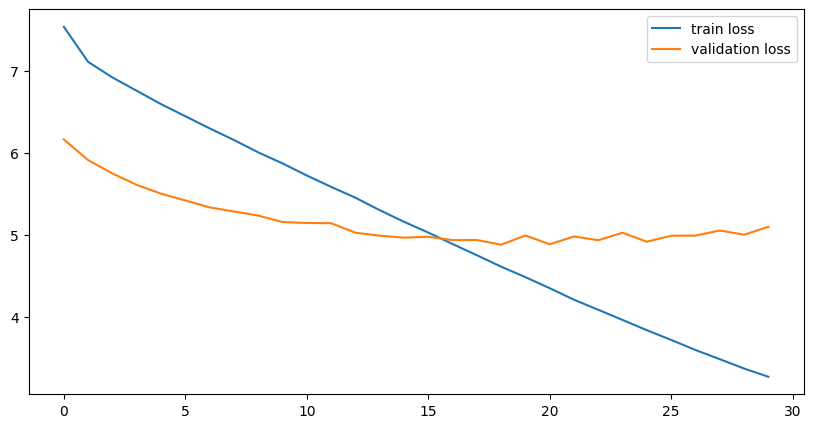

In [82]:
plt.figure(figsize=(10,5))
plt.plot(range(30),loss_check,label="train loss")
plt.plot(range(30),loss_valid_check,label="validation loss")
plt.legend()
plt.show()

# save

In [86]:
torch.save(model,'model.pth')

## weight if necessary

In [87]:
torch.save(model.state_dict(), 'model_weights.pth')

In [88]:
model.eval()

Transformer(
  (sembeddings): Embedding(12812, 256)
  (spositional_embeddings): Embedding(230, 256)
  (tembeddings): Embedding(22067, 256)
  (tpositional_embeddings): Embedding(230, 256)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, element

# Translating essay

In [89]:
def trans(model,sentence,sField,tField,sTokenizer):
    model.eval()
    processed_sentence = sField.process([sTokenizer(sentence)]).to(device)
    trg = ["بداية"]

    for _ in range(60):
        tindices = [tField.vocab.stoi[word] for word in trg]
        ttensor = torch.LongTensor(tindices).unsqueeze(1).to(device) # target tensor
        outputs = model(processed_sentence,ttensor)

        if tField.vocab.itos[outputs.argmax(2)[-1:].item()] == "<unk>":
            continue
        trg.append(tField.vocab.itos[outputs.argmax(2)[-1:].item()])
        if tField.vocab.itos[outputs.argmax(2)[-1:].item()] == "نهاية":
            break
    return " ".join([word for word in trg if word != "<unk>"][1:-1])